# IEEE ICME 2022 Accepted

# Importation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn import manifold
from sklearn.cluster import KMeans
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get Player Trajectory Data

In [2]:
def GetNBAdata(project_root = ''):
    test_data = torch.load(project_root + 'data/position_inorder.pt')
    Category = torch.load(project_root + 'data/category.pt')
    Category = Category.numpy().astype("int32")
    test_data = np.mean(test_data.numpy()[:,0:250].reshape(134,50,5,10), 2)
    NBA_data = test_data[:,:,[0,1]].reshape(134,-1,1,2)
    NBA_data = np.concatenate((NBA_data,test_data[:,:,[2,3]].reshape(134,-1,1,2)),2)
    NBA_data = np.concatenate((NBA_data,test_data[:,:,[4,5]].reshape(134,-1,1,2)),2)
    NBA_data = np.concatenate((NBA_data,test_data[:,:,[6,7]].reshape(134,-1,1,2)),2)
    NBA_data = np.concatenate((NBA_data,test_data[:,:,[8,9]].reshape(134,-1,1,2)),2)
    max2_x = np.max(NBA_data[:,:,:,0])
    max2_y = np.max(NBA_data[:,:,:,1])
    min2_x = np.min(NBA_data[:,:,:,0])
    min2_y = np.min(NBA_data[:,:,:,1])
    NBA_data[:,:,:,0] = 2 * ((NBA_data[:,:,:,0] - min2_x) / (max2_x - min2_x)) - 1
    NBA_data[:,:,:,1] = 2 * ((NBA_data[:,:,:,1] - min2_y) / (max2_y - min2_y)) - 1
    
    Offense_data = []
    another_team = 0
    bigger_dataset = 0
    
    for k in range(5):
        Offense_data_tmp = []
        for j in range(134):
            for i in range(1):
                Offense_data_tmp.append(NBA_data[j][i+0:i+50][:,k+bigger_dataset+another_team][:,[0,1]])
        Offense_data.append(Offense_data_tmp)
    Offense_data = np.array(Offense_data)
    Offense_data = np.transpose(Offense_data,(1,2,0,3)).reshape(-1,50,10)
    
    return Offense_data, Category

In [3]:
def GetSUVdata(train_select = True, project_root = ''):
    if(train_select == True):
        players = np.load(project_root + 'data/T_no_shuffle_pair_data.npy')
        data_len = 12537
    else:
        players = np.load('data/S_no_shuffle_pair_data.npy')
        data_len = 1394
    max_x = np.max(players[:,:,:,0])
    max_y = np.max(players[:,:,:,1])
    min_x = np.min(players[:,:,:,0])
    min_y = np.min(players[:,:,:,1])
    players[:,:,:,0] = 2 * ((players[:,:,:,0] - min_x) / (max_x - min_x)) - 1
    players[:,:,:,1] = 2 * ((players[:,:,:,1] - min_y) / (max_y - min_y)) - 1
    
    X_ball = []
    for j in range(134):
        X_ball.append(players[j][:,[0]][:,:,[0,1]])
    X_ball = np.array(X_ball)
    X_ball = X_ball.reshape(-1,50,2)
    
    X_train = []
    y_train = []
    another_team = 0
    bigger_dataset = 1
    
    for k in range(5):
        X_train_tmp = []
        y_train_tmp = []
        for j in range(data_len):
            for i in range(1):
                X_train_tmp.append(players[j][i+0:i+50][:,k+bigger_dataset+another_team][:,[0,1]])
                y_train_tmp.append(players[j][i+0:i+50][:,k+bigger_dataset+5][:,[0,1]])
        X_train.append(X_train_tmp)
        y_train.append(y_train_tmp)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.transpose(X_train,(1,2,0,3)).reshape(-1,50,10)
    y_train = np.transpose(y_train,(1,2,0,3)).reshape(-1,50,10)
    
    return X_train, y_train, X_ball

In [4]:
def Gettestdata(project_root = ''):
    players_test = np.load('data/output_sample.npy')
    players_test = np.squeeze(players_test,1)
    for i in range(0,22,2):
        if(i == 0):
            players = np.concatenate((np.expand_dims(players_test[:,:,[i]],3),np.expand_dims(players_test[:,:,[i+1]],3)),3)
        else:
            tmp = np.concatenate((np.expand_dims(players_test[:,:,[i]],3),np.expand_dims(players_test[:,:,[i+1]],3)),3)
            players = np.concatenate((players, tmp),2)
    data_len = 1000
    max_x = np.max(players[:,:,:,0])
    max_y = np.max(players[:,:,:,1])
    min_x = np.min(players[:,:,:,0])
    min_y = np.min(players[:,:,:,1])
    players[:,:,:,0] = 2 * ((players[:,:,:,0] - min_x) / (max_x - min_x)) - 1
    players[:,:,:,1] = 2 * ((players[:,:,:,1] - min_y) / (max_y - min_y)) - 1
    
    X_train = []
    y_train = []
    another_team = 0
    bigger_dataset = 1
    
    for k in range(5):
        X_train_tmp = []
        y_train_tmp = []
        for j in range(data_len):
            for i in range(1):
                X_train_tmp.append(players[j][i+0:i+50][:,k+bigger_dataset+another_team][:,[0,1]])
                y_train_tmp.append(players[j][i+0:i+50][:,k+bigger_dataset+5][:,[0,1]])
        X_train.append(X_train_tmp)
        y_train.append(y_train_tmp)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.transpose(X_train,(1,2,0,3)).reshape(-1,50,10)
    y_train = np.transpose(y_train,(1,2,0,3)).reshape(-1,50,10)
    
    return X_train, y_train

# Model Structurre

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.rnn1 = nn.GRU(30, 512, 2, batch_first = True)
        
    def forward(self, x, hn=None):
        x, hn = self.rnn1(x, hn)
        return x, hn

class EncoderToZ(nn.Module):
    def __init__(self, z_dim):
        super(EncoderToZ, self).__init__()
        
        self.w_qs = nn.Linear(1 * 64, 1 * 64, bias=False)
        self.w_ks = nn.Linear(512 * 2, 1 * 64, bias=False)
        self.w_vs = nn.Linear(512 * 2, 1 * 1024, bias=False)
        
        #self.dropout = nn.Dropout(0.5) 
        
        self.fc1 = nn.Linear(512, z_dim)
        self.fc2 = nn.Linear(512, z_dim)
        
    def forward(self, hn):
        sz_b = hn.size(1)
        hn = torch.transpose(hn,0,1).transpose(1,2).reshape(sz_b, 50, -1)
        q = self.w_qs(torch.ones(sz_b, 64,device=device)).view(sz_b, 1, 1, 64)
        k = self.w_ks(hn).view(sz_b, 50, 1, 64)
        v = self.w_vs(hn).view(sz_b, 50, 1, 1024)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        attn = torch.matmul(q, k.transpose(2, 3))
        #attn = self.dropout(F.softmax(attn, dim=-1))
        attn = F.softmax(attn, dim=-1)
        output = torch.matmul(attn, v).view(sz_b, 2, -1).transpose(0,1)
        z_mu, z_logvar = self.fc1(output), self.fc2(output)
        
        return z_mu.view(2,z_mu.shape[1],-1), z_logvar.view(2,z_logvar.shape[1],-1), output, attn
    
class ZToDecoder(nn.Module):
    def __init__(self, z_dim):
        super(ZToDecoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 512)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        return z

class Generator_O(nn.Module):
    def __init__(self):
        super(Generator_O, self).__init__()
        self.rnn1 = nn.GRU(30, 512, 2, batch_first = True)
        self.fc2 = nn.Linear(512, 30)
        
    def forward(self, x, z):
        x, hn = self.rnn1(x, z)
        x = (self.fc2(x))
        return nn.Tanh()(x[:,-1]), hn
    
class Generator_D(nn.Module):
    def __init__(self):
        super(Generator_D, self).__init__()
        self.embedding = nn.Linear(30, 1024)
        self.w_qs = nn.Linear(1024 * 2, 1 * 64, bias=False)
        self.w_ks = nn.Linear(512 * 2, 1 * 64, bias=False)
        self.w_vs = nn.Linear(512 * 2, 1 * 1024, bias=False)
        ##self.attn = nn.Linear(1024 * 2, 50)
        self.attn_combine = nn.Linear(1024, 512)
        
        self.dropout = nn.Dropout(0.5)
        
        self.gru = nn.GRU(512, 512, 2, batch_first = True)
        self.out = nn.Linear(512, 30)
        
    def forward(self, x, z, encoder_hn):
        time_step = encoder_hn.size(2)
        sz_b = encoder_hn.size(1)
        encoder_hn = torch.transpose(encoder_hn,0,1).transpose(1,2).reshape(sz_b, time_step, -1)
        embedded = self.embedding(x).view(len(x), 1, -1)
        embedded = self.dropout(embedded)
        
        cat_input_z = torch.cat((embedded, z.view(len(x), 1, -1)), 2)
        q = self.w_qs(cat_input_z).view(sz_b, 1, 1, 64)
        k = self.w_ks(encoder_hn).view(sz_b, time_step, 1, 64)
        v = self.w_vs(encoder_hn).view(sz_b, time_step, 1, 1024)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        attn = torch.matmul(q, k.transpose(2, 3))
        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v).view(sz_b, 1, -1)
        output = self.attn_combine(output)
        
#         attn_weights = F.softmax(
#             self.attn(torch.cat((embedded, z.view(len(x), 1, -1)), 2)), dim=2)
#         attn_applied = torch.bmm(attn_weights,encoder_hn)
        
#         output = torch.cat((embedded, attn_applied), 2)
#         output = self.attn_combine(output)
        
        output = F.relu(output)
        output, hn = self.gru(output, z)
        x = self.out(output)
        
        return nn.Tanh()(x[:,-1]), hn, attn

# Training and Testing

In [6]:
def Training(X_train, y_train, batch_size = 32, z_dim = 128):

    #data preparation
    batch_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    dataloader = DataLoader(batch_data, batch_size=batch_size, shuffle=True)

    # Construct Model
    netEnc = Encoder().to(device)
    netETZ = EncoderToZ(z_dim).to(device)
    netZTD = ZToDecoder(z_dim).to(device)
    netDec = Generator_O().to(device)
    netDec_D = Generator_D().to(device)
    params = list(netEnc.parameters()) + list(netETZ.parameters()) + list(netZTD.parameters()) + list(netDec.parameters()) + list(netDec_D.parameters())
#     params = list(netEnc.parameters()) + list(netETZ.parameters()) + list(netZTD.parameters()) + list(netDec.parameters())
    
    opt = optim.Adam(params, lr=0.0001, betas=(0.5, 0.999))
#     opt_D = optim.Adam(netDec_D.parameters(), lr=0.0001, betas=(0.5, 0.999))

    # Main Loop
    num_epochs = 100
    #z_fixed = torch.randn(36, z_dim, device=device)
    print("Start Training ...")
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            # Initialize
            netEnc.zero_grad()
            netETZ.zero_grad()
            netZTD.zero_grad()
            netDec.zero_grad()
            netDec_D.zero_grad()
            
            x = data[0].cuda().float()
            y = data[1].cuda().float()

            for j in range(50):
                if (j == 0):
                    tmp_x, tmp_hn = netEnc(x[:,[j]])
                elif (j == 1):
                    tmp_x2, tmp_hn2 = netEnc(x[:,[j]],tmp_hn)
                    encoder_output = torch.cat((tmp_x,tmp_x2),1)
                    hn = torch.cat((torch.unsqueeze(tmp_hn, 2),torch.unsqueeze(tmp_hn2, 2)),2)
                else:
                    tmp_x2, tmp_hn2 = netEnc(x[:,[j]],tmp_hn2)
                    encoder_output = torch.cat((encoder_output,tmp_x2),1)
                    hn = torch.cat((hn,torch.unsqueeze(tmp_hn2, 2)),2)
            
            hn_D = hn
            z_mean, z_logvar, hn, attn = netETZ(hn)
            kl_loss = - 0.5 * torch.sum(1+ z_logvar - z_mean.pow(2) - z_logvar.exp())
            
            z_var = torch.exp(0.5 * z_logvar)
            epsilon = torch.randn_like(z_var).cuda()           
            z = (z_mean + z_var*epsilon)
            z = netZTD(z)
            padding_x = torch.zeros(len(x),1,30,device=device)
            for j in range(50):
                if (j == 0):
                    tmp_x, hn = netDec(padding_x,z)
                    tmp_x = tmp_x.view(-1,1,30)
                elif (j == 1):
                    tmp_x2, hn = netDec(tmp_x,hn)
                    tmp_x2 = tmp_x2.view(-1,1,30)
                    recon_x = torch.cat((tmp_x,tmp_x2),1)
                else:
                    tmp_x2, hn = netDec(tmp_x2,hn)
                    tmp_x2 = tmp_x2.view(-1,1,30)
                    recon_x = torch.cat((recon_x,tmp_x2),1)
            #element_sub = torch.mean(torch.square(torch.subtract(recon_x, x)),-1)
            #attn_mul = torch.mul(attn.reshape(-1,50),50)
            #L2_loss = torch.mean(torch.mul(element_sub,attn_mul))
            rec_loss = nn.MSELoss()(recon_x, x)
            #rec_loss = L2_loss
            
            padding_x = torch.zeros(len(x),1,30,device=device)
            for j in range(50):
                if (j == 0):
                    tmp_x, hn, _ = netDec_D(padding_x,z,hn_D)
                    tmp_x = tmp_x.view(-1,1,30)
                elif (j == 1):
                    tmp_x2, hn, _ = netDec_D(tmp_x,hn,hn_D)
                    tmp_x2 = tmp_x2.view(-1,1,30)
                    recon_y = torch.cat((tmp_x,tmp_x2),1)
                else:
                    tmp_x2, hn, _ = netDec_D(tmp_x2,hn,hn_D)
                    tmp_x2 = tmp_x2.view(-1,1,30)
                    recon_y = torch.cat((recon_y,tmp_x2),1) 
            rec_D_loss = nn.MSELoss()(recon_y, y)

            loss = rec_loss + 0.00001 * kl_loss + rec_D_loss
            loss.backward()
            opt.step()
#             opt_D.step()

            # Show Information
            if i % 100 == 0:
                print("[%d/%d][%s/%d] R_O_loss: %.4f | R_D_loss: %.4f | KL_loss: %.4f"\
                %(epoch+1, num_epochs, str(i).zfill(4), len(dataloader), rec_loss.item(), rec_D_loss.item(), kl_loss.mean().item()))
    return netEnc,netETZ,netZTD,netDec,netDec_D

In [7]:
def Testing(X_test, batch_size = 134, num_step=50):
    batch_data = TensorDataset(torch.tensor(X_test))

    ### Do Not Shuffle!!!!!!!!!!
    dataloader = DataLoader(batch_data, batch_size=batch_size, shuffle=False)
    total_loss = 0
    index = -1
    for x in dataloader:
        index += 1
        x = x[0].float().cuda()
        # ===================forward====================
        for j in range(num_step):
            if (j == 0):
                tmp_x, tmp_hn = netEnc(x[:,[j]])
            elif (j == 1):
                tmp_x2, tmp_hn2 = netEnc(x[:,[j]],tmp_hn)
                encoder_output = torch.cat((tmp_x,tmp_x2),1)
                hn = torch.cat((torch.unsqueeze(tmp_hn, 2),torch.unsqueeze(tmp_hn2, 2)),2)
            else:
                tmp_x2, tmp_hn2 = netEnc(x[:,[j]],tmp_hn2)
                encoder_output = torch.cat((encoder_output,tmp_x2),1)
                hn = torch.cat((hn,torch.unsqueeze(tmp_hn2, 2)),2)
                
        hn_D = hn
        z_mean, z_logvar, hn, attn = netETZ(hn)
        #c = torch.cat((z_mean, z_logvar),2)
        if(index == 0):
            X = hn.cpu().detach().numpy()
            Attn_Score = attn.cpu().detach().numpy()
        else:
            X = np.concatenate((X,hn.cpu().detach().numpy()),1)
            Attn_Score = np.concatenate((Attn_Score,attn.cpu().detach().numpy()),0)
            
        z_var = torch.exp(0.5 * z_logvar)
        epsilon = torch.randn_like(z_var).cuda()           
        z = (z_mean + z_var*epsilon)

        #z = z.view(-1,z.shape[0],z.shape[1])
        z = netZTD(z)
        padding_x = torch.zeros(len(x),1,30,device=device)
        for j in range(num_step):
            if (j == 0):
                tmp_x, hn = netDec(padding_x,z)
                tmp_x = tmp_x.view(-1,1,30)
            elif (j == 1):
                tmp_x2, hn = netDec(tmp_x,hn)
                tmp_x2 = tmp_x2.view(-1,1,30)
                recon_x_O = torch.cat((tmp_x,tmp_x2),1)
            else:
                tmp_x2, hn = netDec(tmp_x2,hn)
                tmp_x2 = tmp_x2.view(-1,1,30)
                recon_x_O = torch.cat((recon_x_O,tmp_x2),1)
        rec_loss = nn.L1Loss()(recon_x_O, x)
        print(rec_loss)
        
        z = netZTD(z_mean)
        #encoder_output = encoder_output.detach()
        #z = z.detach()
        padding_x = torch.zeros(len(x),1,30,device=device)
        for j in range(num_step):
            if (j == 0):
                tmp_x, hn, _ = netDec_D(padding_x,z,hn_D)
                tmp_x = tmp_x.view(-1,1,30)
            elif (j == 1):
                tmp_x2, hn, _ = netDec_D(tmp_x,hn,hn_D)
                tmp_x2 = tmp_x2.view(-1,1,30)
                recon_x_D = torch.cat((tmp_x,tmp_x2),1)
            else:
                tmp_x2, hn, _ = netDec_D(tmp_x2,hn,hn_D)
                tmp_x2 = tmp_x2.view(-1,1,30)
                recon_x_D = torch.cat((recon_x_D,tmp_x2),1)
        
        if(index == 0):
            recon_D_tmp = recon_x_D.cpu().detach()
            recon_O_tmp = recon_x_O.cpu().detach()
        else:
            recon_D_tmp = torch.cat((recon_D_tmp,recon_x_D.cpu().detach()),0)
            recon_O_tmp = torch.cat((recon_O_tmp,recon_x_O.cpu().detach()),0)
        
    return X, recon_O_tmp.cpu().detach().numpy(), recon_D_tmp.cpu().detach().numpy(), Attn_Score, z_mean
#     return X, recon_O_tmp.cpu().detach().numpy(), Attn_Score, z_mean

# Data Visualization

In [8]:
def draw_play(draw_O, draw_D, X_ball, index = 0):
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax = fig.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    img = mpimg.imread('nba_court_T.png')
    ax.imshow(img,extent=[-1,1,-1,1], zorder=10)

    line, = ax.plot([], [], color='blue', linestyle='-', linewidth=2, alpha=0.3)
    line2, = ax.plot([], [], color='blue', linestyle='-', linewidth=2, alpha=0.3)
    line3, = ax.plot([], [], color='blue', linestyle='-', linewidth=2, alpha=0.3)
    line4, = ax.plot([], [], color='blue', linestyle='-', linewidth=2, alpha=0.3)
    line5, = ax.plot([], [], color='blue', linestyle='-', linewidth=2, alpha=0.3)
    line6, = ax.plot([], [], color='red', linestyle='-', linewidth=2, alpha=0.3)
    line7, = ax.plot([], [], color='red', linestyle='-', linewidth=2, alpha=0.3)
    line8, = ax.plot([], [], color='red', linestyle='-', linewidth=2, alpha=0.3)
    line9, = ax.plot([], [], color='red', linestyle='-', linewidth=2, alpha=0.3)
    line10, = ax.plot([], [], color='red', linestyle='-', linewidth=2, alpha=0.3)
    lineB, = ax.plot([], [], color='green', linestyle='-', linewidth=2, alpha=0.3)
    dot, = ax.plot([], [], color='blue', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot2, = ax.plot([], [], color='blue', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot3, = ax.plot([], [], color='blue', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot4, = ax.plot([], [], color='blue', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot5, = ax.plot([], [], color='blue', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot6, = ax.plot([], [], color='red', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot7, = ax.plot([], [], color='red', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot8, = ax.plot([], [], color='red', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot9, = ax.plot([], [], color='red', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot10, = ax.plot([], [], color='red', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dotB, = ax.plot([], [], color='green', marker='o', markersize=10, markeredgecolor='black', linestyle='')
    dot_, = ax.plot([], [], color='blue', marker='$1$', markersize=7, markeredgecolor='white', linestyle='')
    dot2_, = ax.plot([], [], color='blue', marker='$2$', markersize=7, markeredgecolor='white', linestyle='')
    dot3_, = ax.plot([], [], color='blue', marker='$3$', markersize=7, markeredgecolor='white', linestyle='')
    dot4_, = ax.plot([], [], color='blue', marker='$4$', markersize=7, markeredgecolor='white', linestyle='')
    dot5_, = ax.plot([], [], color='blue', marker='$5$', markersize=7, markeredgecolor='white', linestyle='')
    dot6_, = ax.plot([], [], color='red', marker='$1$', markersize=7, markeredgecolor='white', linestyle='')
    dot7_, = ax.plot([], [], color='red', marker='$2$', markersize=7, markeredgecolor='white', linestyle='')
    dot8_, = ax.plot([], [], color='red', marker='$3$', markersize=7, markeredgecolor='white', linestyle='')
    dot9_, = ax.plot([], [], color='red', marker='$4$', markersize=7, markeredgecolor='white', linestyle='')
    dot10_, = ax.plot([], [], color='red', marker='$5$', markersize=7, markeredgecolor='white', linestyle='')


    def update(i):
        line.set_data(draw_O[index][:,[0]].reshape(-1)[:i], draw_O[index][:,[1]].reshape(-1)[:i])
        line2.set_data(draw_O[index][:,[2]].reshape(-1)[:i], draw_O[index][:,[3]].reshape(-1)[:i])
        line3.set_data(draw_O[index][:,[4]].reshape(-1)[:i], draw_O[index][:,[5]].reshape(-1)[:i])
        line4.set_data(draw_O[index][:,[6]].reshape(-1)[:i], draw_O[index][:,[7]].reshape(-1)[:i])
        line5.set_data(draw_O[index][:,[8]].reshape(-1)[:i], draw_O[index][:,[9]].reshape(-1)[:i])
        line6.set_data(draw_D[index][:,[0]].reshape(-1)[:i], draw_D[index][:,[1]].reshape(-1)[:i])
        line7.set_data(draw_D[index][:,[2]].reshape(-1)[:i], draw_D[index][:,[3]].reshape(-1)[:i])
        line8.set_data(draw_D[index][:,[4]].reshape(-1)[:i], draw_D[index][:,[5]].reshape(-1)[:i])
        line9.set_data(draw_D[index][:,[6]].reshape(-1)[:i], draw_D[index][:,[7]].reshape(-1)[:i])
        line10.set_data(draw_D[index][:,[8]].reshape(-1)[:i], draw_D[index][:,[9]].reshape(-1)[:i])
        lineB.set_data(X_ball[index][:,[0]].reshape(-1)[:i], X_ball[index][:,[1]].reshape(-1)[:i])

        dot.set_data(draw_O[index][:,[0]].reshape(-1)[i], draw_O[index][:,[1]].reshape(-1)[i])
        dot2.set_data(draw_O[index][:,[2]].reshape(-1)[i], draw_O[index][:,[3]].reshape(-1)[i])
        dot3.set_data(draw_O[index][:,[4]].reshape(-1)[i], draw_O[index][:,[5]].reshape(-1)[i])
        dot4.set_data(draw_O[index][:,[6]].reshape(-1)[i], draw_O[index][:,[7]].reshape(-1)[i])
        dot5.set_data(draw_O[index][:,[8]].reshape(-1)[i], draw_O[index][:,[9]].reshape(-1)[i])
        dot6.set_data(draw_D[index][:,[0]].reshape(-1)[i], draw_D[index][:,[1]].reshape(-1)[i])
        dot7.set_data(draw_D[index][:,[2]].reshape(-1)[i], draw_D[index][:,[3]].reshape(-1)[i])
        dot8.set_data(draw_D[index][:,[4]].reshape(-1)[i], draw_D[index][:,[5]].reshape(-1)[i])
        dot9.set_data(draw_D[index][:,[6]].reshape(-1)[i], draw_D[index][:,[7]].reshape(-1)[i])
        dot10.set_data(draw_D[index][:,[8]].reshape(-1)[i], draw_D[index][:,[9]].reshape(-1)[i])
        dotB.set_data(X_ball[index][:,[0]].reshape(-1)[i], X_ball[index][:,[1]].reshape(-1)[i])

        dot_.set_data(draw_O[index][:,[0]].reshape(-1)[i], draw_O[index][:,[1]].reshape(-1)[i])
        dot2_.set_data(draw_O[index][:,[2]].reshape(-1)[i], draw_O[index][:,[3]].reshape(-1)[i])
        dot3_.set_data(draw_O[index][:,[4]].reshape(-1)[i], draw_O[index][:,[5]].reshape(-1)[i])
        dot4_.set_data(draw_O[index][:,[6]].reshape(-1)[i], draw_O[index][:,[7]].reshape(-1)[i])
        dot5_.set_data(draw_O[index][:,[8]].reshape(-1)[i], draw_O[index][:,[9]].reshape(-1)[i])
        dot6_.set_data(draw_D[index][:,[0]].reshape(-1)[i], draw_D[index][:,[1]].reshape(-1)[i])
        dot7_.set_data(draw_D[index][:,[2]].reshape(-1)[i], draw_D[index][:,[3]].reshape(-1)[i])
        dot8_.set_data(draw_D[index][:,[4]].reshape(-1)[i], draw_D[index][:,[5]].reshape(-1)[i])
        dot9_.set_data(draw_D[index][:,[6]].reshape(-1)[i], draw_D[index][:,[7]].reshape(-1)[i])
        dot10_.set_data(draw_D[index][:,[8]].reshape(-1)[i], draw_D[index][:,[9]].reshape(-1)[i])

        return dot,dot2,dot3,dot4,dot5,dot6,dot7,dot8,dot9,dot10,dot_,dot2_,dot3_,dot4_,dot5_\
            ,dot6_,dot7_,dot8_,dot9_,dot10_,line,line2,line3,line4,line5,line6,line7,line8,line9,line10,lineB,dotB

    def init():
        line.set_data(draw_O[index][:,[0]].reshape(-1)[0], draw_O[index][:,[1]].reshape(-1)[0])
        line2.set_data(draw_O[index][:,[2]].reshape(-1)[0], draw_O[index][:,[3]].reshape(-1)[0])
        line3.set_data(draw_O[index][:,[4]].reshape(-1)[0], draw_O[index][:,[5]].reshape(-1)[0])
        line4.set_data(draw_O[index][:,[6]].reshape(-1)[0], draw_O[index][:,[7]].reshape(-1)[0])
        line5.set_data(draw_O[index][:,[8]].reshape(-1)[0], draw_O[index][:,[9]].reshape(-1)[0])
        line6.set_data(draw_D[index][:,[0]].reshape(-1)[0], draw_D[index][:,[1]].reshape(-1)[0])
        line7.set_data(draw_D[index][:,[2]].reshape(-1)[0], draw_D[index][:,[3]].reshape(-1)[0])
        line8.set_data(draw_D[index][:,[4]].reshape(-1)[0], draw_D[index][:,[5]].reshape(-1)[0])
        line9.set_data(draw_D[index][:,[6]].reshape(-1)[0], draw_D[index][:,[7]].reshape(-1)[0])
        line10.set_data(draw_D[index][:,[8]].reshape(-1)[0], draw_D[index][:,[9]].reshape(-1)[0])
        lineB.set_data(X_ball[index][:,[0]].reshape(-1)[0], X_ball[index][:,[1]].reshape(-1)[0])

        dot.set_data(draw_O[index][:,[0]].reshape(-1)[0], draw_O[index][:,[1]].reshape(-1)[0])
        dot2.set_data(draw_O[index][:,[2]].reshape(-1)[0], draw_O[index][:,[3]].reshape(-1)[0])
        dot3.set_data(draw_O[index][:,[4]].reshape(-1)[0], draw_O[index][:,[5]].reshape(-1)[0])
        dot4.set_data(draw_O[index][:,[6]].reshape(-1)[0], draw_O[index][:,[7]].reshape(-1)[0])
        dot5.set_data(draw_O[index][:,[8]].reshape(-1)[0], draw_O[index][:,[9]].reshape(-1)[0])
        dot6.set_data(draw_D[index][:,[0]].reshape(-1)[0], draw_D[index][:,[1]].reshape(-1)[0])
        dot7.set_data(draw_D[index][:,[2]].reshape(-1)[0], draw_D[index][:,[3]].reshape(-1)[0])
        dot8.set_data(draw_D[index][:,[4]].reshape(-1)[0], draw_D[index][:,[5]].reshape(-1)[0])
        dot9.set_data(draw_D[index][:,[6]].reshape(-1)[0], draw_D[index][:,[7]].reshape(-1)[0])
        dot10.set_data(draw_D[index][:,[8]].reshape(-1)[0], draw_D[index][:,[9]].reshape(-1)[0])
        dotB.set_data(X_ball[index][:,[0]].reshape(-1)[0], X_ball[index][:,[1]].reshape(-1)[0])

        dot_.set_data(draw_O[index][:,[0]].reshape(-1)[0], draw_O[index][:,[1]].reshape(-1)[0])
        dot2_.set_data(draw_O[index][:,[2]].reshape(-1)[0], draw_O[index][:,[3]].reshape(-1)[0])
        dot3_.set_data(draw_O[index][:,[4]].reshape(-1)[0], draw_O[index][:,[5]].reshape(-1)[0])
        dot4_.set_data(draw_O[index][:,[6]].reshape(-1)[0], draw_O[index][:,[7]].reshape(-1)[0])
        dot5_.set_data(draw_O[index][:,[8]].reshape(-1)[0], draw_O[index][:,[9]].reshape(-1)[0])
        dot6_.set_data(draw_D[index][:,[0]].reshape(-1)[0], draw_D[index][:,[1]].reshape(-1)[0])
        dot7_.set_data(draw_D[index][:,[2]].reshape(-1)[0], draw_D[index][:,[3]].reshape(-1)[0])
        dot8_.set_data(draw_D[index][:,[4]].reshape(-1)[0], draw_D[index][:,[5]].reshape(-1)[0])
        dot9_.set_data(draw_D[index][:,[6]].reshape(-1)[0], draw_D[index][:,[7]].reshape(-1)[0])
        dot10_.set_data(draw_D[index][:,[8]].reshape(-1)[0], draw_D[index][:,[9]].reshape(-1)[0])
        return dot,dot2,dot3,dot4,dot5,dot6,dot7,dot8,dot9,dot10,dot_,dot2_,dot3_,dot4_,dot5_\
            ,dot6_,dot7_,dot8_,dot9_,dot10_,line,line2,line3,line4,line5,line6,line7,line8,line9,line10,lineB,dotB
    title = "new_test.mp4"
    ani = animation.FuncAnimation(fig=fig, func=update, frames=50, init_func=init, blit=True, repeat=True)
    ani.save(title, writer='ffmpeg', fps=8)

#  Main - Loading and Saving Model

In [48]:
#save_model
project_root = ""
file_path = os.path.join(project_root, "save_thesis")
torch.save(netEnc.state_dict(), file_path+"/netEnc_FT.pt")
torch.save(netETZ.state_dict(), file_path+"/netETZ_FT.pt")
torch.save(netZTD.state_dict(), file_path+"/netZTD_FT.pt")
torch.save(netDec.state_dict(), file_path+"/netDecO_FT.pt")
torch.save(netDec_D.state_dict(), file_path+"/netDecD_FT.pt")

In [18]:
#load_model
project_root = ""
file_path = os.path.join(project_root, "save_ablation")
netEnc = Encoder().to(device)
netETZ = EncoderToZ(128).to(device)
netZTD = ZToDecoder(128).to(device)
netDec = Generator_O().to(device)
netDec_D = Generator_D().to(device)
netEnc.load_state_dict(torch.load(file_path+"/netEnc_FT.pt"))
netETZ.load_state_dict(torch.load(file_path+"/netETZ_FT.pt"))
netZTD.load_state_dict(torch.load(file_path+"/netZTD_FT.pt"))
netDec.load_state_dict(torch.load(file_path+"/netDecO_FT.pt"))
netDec_D.load_state_dict(torch.load(file_path+"/netDecD_FT.pt"))

<All keys matched successfully>

# Main - Get Data

In [9]:
Offense_train, Defense_train, Ball_draw = GetSUVdata()
# NBA_testing, Category = GetNBAdata()
# O_data, D_data, Ball_data = GetSUVdata(False)
O_data, D_data = Gettestdata()

# Main - Adding Acceleration and Velocity

In [10]:
P_train = Offense_train.reshape(-1,50,5,2)
PD_train = Defense_train.reshape(-1,50,5,2)
V_train = np.concatenate((np.diff(Offense_train,axis=1,n=2),np.zeros((12537, 2, 10))),1).reshape(-1,50,5,2)
VD_train = np.concatenate((np.diff(Defense_train,axis=1,n=2),np.zeros((12537, 2, 10))),1).reshape(-1,50,5,2)
A_train = np.concatenate((np.diff(Offense_train,axis=1,n=1),np.zeros((12537, 1, 10))),1).reshape(-1,50,5,2)
AD_train = np.concatenate((np.diff(Defense_train,axis=1,n=1),np.zeros((12537, 1, 10))),1).reshape(-1,50,5,2)
O_train = np.concatenate((P_train,V_train,A_train),-1).reshape(-1,50,30)
D_train = np.concatenate((PD_train,VD_train,AD_train),-1).reshape(-1,50,30)

In [11]:
P_test = O_data.reshape(-1,50,5,2)
PD_test = D_data.reshape(-1,50,5,2)
V_test = np.concatenate((np.diff(O_data,axis=1,n=2),np.zeros((1000, 2, 10))),1).reshape(-1,50,5,2)
VD_test = np.concatenate((np.diff(D_data,axis=1,n=2),np.zeros((1000, 2, 10))),1).reshape(-1,50,5,2)
A_test = np.concatenate((np.diff(O_data,axis=1,n=1),np.zeros((1000, 1, 10))),1).reshape(-1,50,5,2)
AD_test = np.concatenate((np.diff(D_data,axis=1,n=1),np.zeros((1000, 1, 10))),1).reshape(-1,50,5,2)
O_test = np.concatenate((P_test,V_test,A_test),-1).reshape(-1,50,30)
D_test = np.concatenate((PD_test,VD_test,AD_test),-1).reshape(-1,50,30)

# Main - Draw Ground Truth

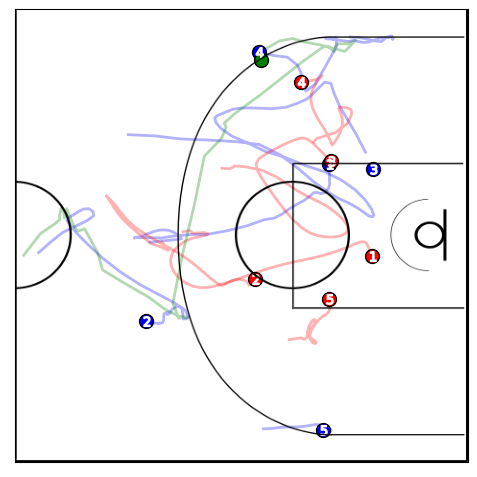

In [105]:
draw_play(O_data[0:134], recon_D[0:134], Ball_data, 5)

# Main - Training

In [47]:
netEnc,netETZ,netZTD,netDec,netDec_D = Training(O_train, D_train)

Start Training ...
[1/100][0000/392] R_O_loss: 0.0770 | R_D_loss: 0.0410 | KL_loss: 5.1936
[1/100][0100/392] R_O_loss: 0.0710 | R_D_loss: 0.0134 | KL_loss: 31.8065
[1/100][0200/392] R_O_loss: 0.0561 | R_D_loss: 0.0089 | KL_loss: 146.6492
[1/100][0300/392] R_O_loss: 0.0480 | R_D_loss: 0.0070 | KL_loss: 266.4156
[2/100][0000/392] R_O_loss: 0.0433 | R_D_loss: 0.0063 | KL_loss: 308.5319
[2/100][0100/392] R_O_loss: 0.0415 | R_D_loss: 0.0059 | KL_loss: 305.7254
[2/100][0200/392] R_O_loss: 0.0385 | R_D_loss: 0.0071 | KL_loss: 308.6570
[2/100][0300/392] R_O_loss: 0.0398 | R_D_loss: 0.0064 | KL_loss: 318.7260
[3/100][0000/392] R_O_loss: 0.0430 | R_D_loss: 0.0060 | KL_loss: 296.6901
[3/100][0100/392] R_O_loss: 0.0372 | R_D_loss: 0.0051 | KL_loss: 354.4623
[3/100][0200/392] R_O_loss: 0.0393 | R_D_loss: 0.0054 | KL_loss: 364.7516
[3/100][0300/392] R_O_loss: 0.0362 | R_D_loss: 0.0062 | KL_loss: 374.3969
[4/100][0000/392] R_O_loss: 0.0376 | R_D_loss: 0.0061 | KL_loss: 370.8852
[4/100][0100/392] R_O_

[28/100][0200/392] R_O_loss: 0.0118 | R_D_loss: 0.0045 | KL_loss: 695.6378
[28/100][0300/392] R_O_loss: 0.0145 | R_D_loss: 0.0042 | KL_loss: 729.2343
[29/100][0000/392] R_O_loss: 0.0130 | R_D_loss: 0.0040 | KL_loss: 709.9952
[29/100][0100/392] R_O_loss: 0.0144 | R_D_loss: 0.0049 | KL_loss: 743.0696
[29/100][0200/392] R_O_loss: 0.0137 | R_D_loss: 0.0062 | KL_loss: 710.9924
[29/100][0300/392] R_O_loss: 0.0126 | R_D_loss: 0.0062 | KL_loss: 726.8436
[30/100][0000/392] R_O_loss: 0.0130 | R_D_loss: 0.0049 | KL_loss: 760.7511
[30/100][0100/392] R_O_loss: 0.0130 | R_D_loss: 0.0052 | KL_loss: 714.7551
[30/100][0200/392] R_O_loss: 0.0126 | R_D_loss: 0.0062 | KL_loss: 676.2432
[30/100][0300/392] R_O_loss: 0.0129 | R_D_loss: 0.0061 | KL_loss: 736.7042
[31/100][0000/392] R_O_loss: 0.0113 | R_D_loss: 0.0057 | KL_loss: 741.8737
[31/100][0100/392] R_O_loss: 0.0126 | R_D_loss: 0.0047 | KL_loss: 699.0321
[31/100][0200/392] R_O_loss: 0.0117 | R_D_loss: 0.0035 | KL_loss: 702.8285
[31/100][0300/392] R_O_lo

[56/100][0000/392] R_O_loss: 0.0109 | R_D_loss: 0.0045 | KL_loss: 788.5817
[56/100][0100/392] R_O_loss: 0.0124 | R_D_loss: 0.0048 | KL_loss: 742.2496
[56/100][0200/392] R_O_loss: 0.0103 | R_D_loss: 0.0052 | KL_loss: 740.6830
[56/100][0300/392] R_O_loss: 0.0098 | R_D_loss: 0.0062 | KL_loss: 752.9263
[57/100][0000/392] R_O_loss: 0.0104 | R_D_loss: 0.0049 | KL_loss: 773.0543
[57/100][0100/392] R_O_loss: 0.0094 | R_D_loss: 0.0041 | KL_loss: 743.4498
[57/100][0200/392] R_O_loss: 0.0105 | R_D_loss: 0.0034 | KL_loss: 758.0349
[57/100][0300/392] R_O_loss: 0.0107 | R_D_loss: 0.0044 | KL_loss: 773.7676
[58/100][0000/392] R_O_loss: 0.0097 | R_D_loss: 0.0043 | KL_loss: 765.6050
[58/100][0100/392] R_O_loss: 0.0104 | R_D_loss: 0.0041 | KL_loss: 772.6269
[58/100][0200/392] R_O_loss: 0.0102 | R_D_loss: 0.0043 | KL_loss: 764.0497
[58/100][0300/392] R_O_loss: 0.0113 | R_D_loss: 0.0036 | KL_loss: 760.1135
[59/100][0000/392] R_O_loss: 0.0110 | R_D_loss: 0.0040 | KL_loss: 778.3207
[59/100][0100/392] R_O_lo

[83/100][0200/392] R_O_loss: 0.0089 | R_D_loss: 0.0036 | KL_loss: 780.7853
[83/100][0300/392] R_O_loss: 0.0103 | R_D_loss: 0.0031 | KL_loss: 768.8159
[84/100][0000/392] R_O_loss: 0.0097 | R_D_loss: 0.0034 | KL_loss: 791.9630
[84/100][0100/392] R_O_loss: 0.0094 | R_D_loss: 0.0026 | KL_loss: 778.9822
[84/100][0200/392] R_O_loss: 0.0089 | R_D_loss: 0.0034 | KL_loss: 796.3052
[84/100][0300/392] R_O_loss: 0.0083 | R_D_loss: 0.0032 | KL_loss: 772.0880
[85/100][0000/392] R_O_loss: 0.0089 | R_D_loss: 0.0034 | KL_loss: 762.6266
[85/100][0100/392] R_O_loss: 0.0089 | R_D_loss: 0.0035 | KL_loss: 771.0111
[85/100][0200/392] R_O_loss: 0.0090 | R_D_loss: 0.0029 | KL_loss: 758.3469
[85/100][0300/392] R_O_loss: 0.0092 | R_D_loss: 0.0030 | KL_loss: 776.2160
[86/100][0000/392] R_O_loss: 0.0090 | R_D_loss: 0.0033 | KL_loss: 816.1407
[86/100][0100/392] R_O_loss: 0.0095 | R_D_loss: 0.0027 | KL_loss: 742.0619
[86/100][0200/392] R_O_loss: 0.0091 | R_D_loss: 0.0036 | KL_loss: 773.1497
[86/100][0300/392] R_O_lo

# Main - Latent Train Test Split

In [168]:
X_train, X_test, Category_train, Category_test = train_test_split(O_train, 
                                                                  Category, test_size=0.2, random_state=0)
Category_tmp = np.concatenate((Category_train,Category_test),0)
X_all = np.concatenate((X_train,X_test),0)

# Main - Get Latent and Defense Generation

In [53]:
netEnc.eval()
netETZ.eval()
netZTD.eval()
netDec.eval()
netDec_D.eval()
X, recon_O, recon_D, Attn_Score, _ = Testing(O_test)
recon_D = recon_D[:,:,[0,1,6,7,12,13,18,19,24,25]]
D_data = D_test

tensor(0.0497, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0505, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0501, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0522, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0519, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0520, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0532, device='cuda:0', grad_fn=<L1LossBackward0>)
tensor(0.0552, device='cuda:0', grad_fn=<L1LossBackward0>)


# Main - Draw Generation

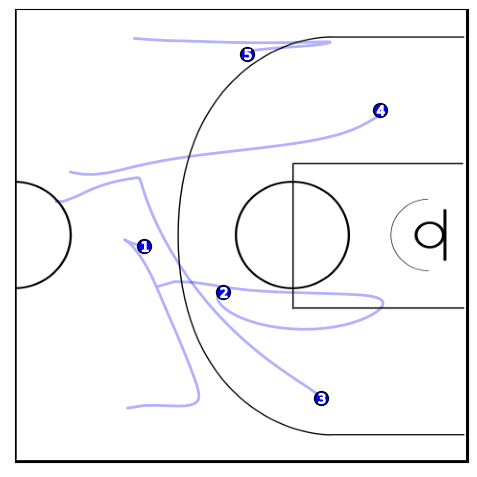

In [20]:
draw_play(recon_O[0:134], recon_D[0:134], Ball_data[0:134], 0)

# Main - Uncertainty Testing

In [115]:
uncertainty = recon_D[0].reshape(1,50,10)

In [123]:
uncertainty = np.concatenate((uncertainty,recon_O[0].reshape(1,50,10)),0)

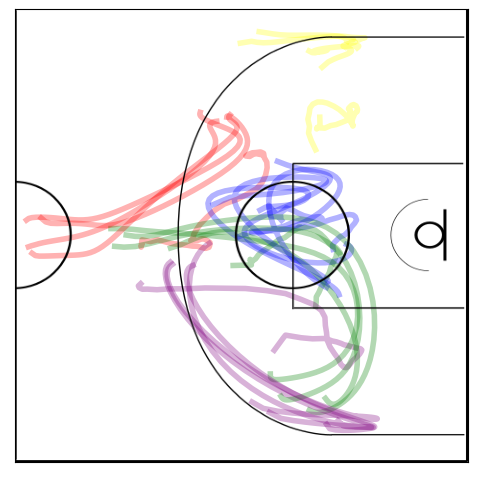

In [124]:
draw_O = uncertainty
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.gca()

import matplotlib.image as mpimg
img = mpimg.imread('nba_court_T.png')
ax.imshow(img,extent=[-1,1,-1,1], zorder=10)

for index in range(5):
    line, = ax.plot([], [], color='red', linestyle='-', linewidth=4, alpha=0.3)
    line2, = ax.plot([], [], color='blue', linestyle='-', linewidth=4, alpha=0.3)
    line3, = ax.plot([], [], color='green', linestyle='-', linewidth=4, alpha=0.3)
    line4, = ax.plot([], [], color='purple', linestyle='-', linewidth=4, alpha=0.3)
    line5, = ax.plot([], [], color='yellow', linestyle='-', linewidth=4, alpha=0.3)
    line.set_data(draw_O[index][:,[0]].reshape(-1), draw_O[index][:,[1]].reshape(-1))
    line2.set_data(draw_O[index][:,[2]].reshape(-1), draw_O[index][:,[3]].reshape(-1))
    line3.set_data(draw_O[index][:,[4]].reshape(-1), draw_O[index][:,[5]].reshape(-1))
    line4.set_data(draw_O[index][:,[6]].reshape(-1), draw_O[index][:,[7]].reshape(-1))
    line5.set_data(draw_O[index][:,[8]].reshape(-1), draw_O[index][:,[9]].reshape(-1))


    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()
title = str(11) + "_uncertainty_D.jpg"
fig.savefig(title)

# Main - Generation Quality

In [72]:
import math
error = [0] * 5
for i in range(1000):
    for j in range(50):
        for k in range(0,10,2):
            if(j == 0):
                continue
            elif(j==1):
                point1_1 = ((recon_D[i][j-1][k] + 1)/2*a + min_x , (recon_D[i][j-1][k+1] + 1)/2*b + min_y)
                point1_2 = ((recon_D[i][j][k] + 1)/2*a + min_x , (recon_D[i][j][k+1] + 1)/2*b + min_y)
                point2_1 = ((D_data[i][j-1][k] + 1)/2*a + min_x, (D_data[i][j-1][k+1] + 1)/2*b + min_y)
                point2_2 = ((D_data[i][j][k] + 1)/2*a + min_x, (D_data[i][j][k+1] + 1)/2*b + min_y)
                gen_v2 = math.dist(point1_1, point1_2)
                real_v2 = math.dist(point2_1, point2_2)
                
                error[int(j/10)] = error[int(j/10)] + ((gen_v2 - 0) - (real_v2 - 0))/50000
            else:
                point1_1 = ((recon_D[i][j-2][k] + 1)/2*a + min_x , (recon_D[i][j-2][k+1] + 1)/2*b + min_y)
                point1_2 = ((recon_D[i][j-1][k] + 1)/2*a + min_x , (recon_D[i][j-1][k+1] + 1)/2*b + min_y)
                point1_3 = ((recon_D[i][j][k] + 1)/2*a + min_x , (recon_D[i][j][k+1] + 1)/2*b + min_y)
                                   
                point2_1 = ((D_data[i][j-2][k] + 1)/2*a + min_x, (D_data[i][j-2][k+1] + 1)/2*b + min_y)
                point2_2 = ((D_data[i][j-1][k] + 1)/2*a + min_x, (D_data[i][j-1][k+1] + 1)/2*b + min_y)
                point2_3 = ((D_data[i][j][k] + 1)/2*a + min_x, (D_data[i][j][k+1] + 1)/2*b + min_y)
                                   
                gen_v2 = math.dist(point1_2, point1_3)
                gen_v1 = math.dist(point1_1, point1_2)
                real_v2 = math.dist(point2_2, point2_3)
                real_v1 = math.dist(point2_1, point2_2)
                error[int(j/10)] = error[int(j/10)] + ((gen_v2 - gen_v1) - (real_v2 - real_v1))/50000

In [73]:
print(error)
print(np.sum(error)/5)

[-0.0022647285796812155, 0.005453971191502668, 0.0008633322955189047, -0.0008834199686671679, -0.028390142472501986]
-0.00504419750676576


In [70]:
import math
error = [0] * 5
for i in range(1000):
    for j in range(50):
        for k in range(0,10,2):
            if(j != 0):
                point1_1 = ((recon_D[i][j-1][k] + 1)/2*a + min_x , (recon_D[i][j-1][k+1] + 1)/2*b + min_y)
                point1_2 = ((recon_D[i][j][k] + 1)/2*a + min_x , (recon_D[i][j][k+1] + 1)/2*b + min_y)
                point2_1 = ((D_data[i][j-1][k] + 1)/2*a + min_x, (D_data[i][j-1][k+1] + 1)/2*b + min_y)
                point2_2 = ((D_data[i][j][k] + 1)/2*a + min_x, (D_data[i][j][k+1] + 1)/2*b + min_y)
                gen_v = math.dist(point1_1, point1_2)
                real_v = math.dist(point2_1, point2_2)
                error[int(j/10)] = error[int(j/10)] + (gen_v - real_v)/50000

In [71]:
print(error)
print(np.sum(error)/5)

[0.1946131537484685, 0.025624375859501617, 0.04963546662236142, 0.023586267552750288, -0.10322282217939634]
0.038047288320737095


In [68]:
import math
error = [0] * 5
for i in range(1000):
    for j in range(50):
        for k in range(0,10,2):
            point1 = ((recon_D[i][j][k] + 1)/2*a + min_x , (recon_D[i][j][k+1] + 1)/2*b + min_y)
            point2 = ((D_data[i][j][k] + 1)/2*a + min_x, (D_data[i][j][k+1] + 1)/2*b + min_y)
            error[int(j/10)] = error[int(j/10)] + (math.dist(point1, point2)/50000)

In [69]:
print(error)
print(np.sum(error)/5)

[3.702804050805214, 3.2256696810348506, 3.316891785136617, 3.7365578394980266, 4.17958749534557]
3.6323021703640554


# Main - Latent Unsupervised Clustering

In [173]:
X = np.array(X)
X = np.transpose(X,(1,0,2))
X = X.reshape(-1,1024)

In [175]:
X_norm_train = X[0:107]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_norm_train)
output = kmeans.predict(X)
kmeans.labels_

array([5, 2, 0, 0, 4, 4, 7, 6, 7, 6, 5, 3, 5, 8, 9, 5, 0, 4, 8, 6, 4, 6,
       4, 5, 4, 2, 1, 2, 1, 3, 2, 0, 9, 1, 6, 4, 3, 3, 3, 0, 3, 6, 1, 1,
       0, 6, 9, 0, 6, 8, 5, 4, 6, 0, 4, 5, 2, 0, 9, 2, 0, 3, 5, 4, 1, 0,
       7, 6, 3, 9, 0, 8, 7, 4, 2, 5, 7, 2, 2, 2, 9, 7, 2, 2, 9, 0, 2, 1,
       8, 5, 0, 4, 5, 5, 6, 1, 3, 2, 3, 0, 1, 9, 6, 4, 5, 1, 8],
      dtype=int32)

In [176]:
Category_train

array([4, 5, 2, 2, 7, 7, 9, 6, 9, 0, 4, 6, 4, 3, 1, 4, 2, 7, 3, 0, 7, 0,
       7, 4, 7, 5, 8, 5, 8, 6, 5, 2, 1, 8, 0, 7, 6, 6, 6, 2, 6, 0, 8, 8,
       2, 0, 1, 2, 0, 3, 8, 7, 0, 2, 2, 4, 5, 2, 1, 5, 2, 6, 4, 7, 8, 2,
       9, 0, 6, 1, 2, 3, 9, 7, 5, 4, 9, 5, 5, 5, 1, 9, 5, 5, 1, 2, 5, 8,
       3, 8, 2, 7, 4, 4, 0, 8, 6, 5, 6, 2, 8, 1, 0, 7, 4, 8, 3],
      dtype=int32)

In [177]:
relabel_train = np.choose(kmeans.labels_,[2,8,5,6,7,4,0,9,3,1]).astype(np.int32)
relabel_all = np.choose(output,[2,8,5,6,7,4,0,9,3,1]).astype(np.int32)

In [178]:
train_cnt = 0
for i in range(107):
    if(relabel_train[i] == Category_train[i]):
        train_cnt += 1
print("Training Acc: ", train_cnt/107)

all_cnt = 0
for i in range(134):
    if(relabel_all[i] == Category_tmp[i]):
        all_cnt += 1
print("All Acc: ", all_cnt/134)

print("Testing Acc: ", (all_cnt - train_cnt)/(134 - 107))

Training Acc:  0.9626168224299065
All Acc:  0.9701492537313433
Testing Acc:  1.0


# Main - TSNE Visualization

In [180]:
#X_shuffled,y_shuffled = shuffle(X, Category_train, random_state=0)
X_tsne = manifold.TSNE(n_components=2, init='random', random_state=0, verbose=1, perplexity=30).fit_transform(X)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
# X_norm_test = X_norm[0:134]
# X_norm_train = X_norm[134:-1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134 samples in 0.000s...
[t-SNE] Computed neighbors for 134 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 134 / 134
[t-SNE] Mean sigma: 0.290402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.924839
[t-SNE] KL divergence after 850 iterations: 0.131176


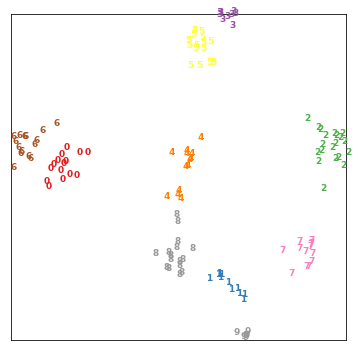

In [182]:
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  #Normalize
#fig_save = plt.figure(figsize=(8, 8))
fig_save = plt.figure(figsize=(6, 6))
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
#ax = fig_save.add_subplot(projection='3d')
for i in range(0,134):
    #plt.scatter(X_norm[i, 0], X_norm[i, 1], color="gray",alpha=0.3)
#     c = "gray"
    c = plt.cm.Set1(int(Category_tmp[i]))
    plt.text(X_norm[i, 0], X_norm[i, 1],str(int(Category_tmp[i])), color=c, 
             fontdict={'weight': 'bold', 'size': 9},alpha=1)
# for i in range(1394,1528):
#     if(int(Category_tmp[i-1394]) == 8):
#         c = "navy"
#     elif(int(Category_tmp[i-1394]) == 9):
#         c = "teal"
#     else:
#         c = plt.cm.Set1(int(Category_tmp[i-1394]))
#     plt.text(X_norm[i, 0], X_norm[i, 1],str(int(Category_tmp[i-1394])), color=c, 
#              fontdict={'weight': 'bold', 'size': 9})
plt.show()
fig_save.savefig("new_latent_thesis.jpg")